In [1]:
%matplotlib inline
import random

import numpy as np
import torch
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
from bindsnet.network.nodes import Input, LIFNodes, IzhikevichNodes
from bindsnet.learning import PostPre
from bindsnet.network.topology import Connection
from bindsnet.encoding.encoders import BernoulliEncoder

# from .RandomConnection import RandomConnection

In [2]:
from libs.connections import RandomConnection
from libs.learning import PostPreInh

In [3]:
seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

In [4]:
device = "cpu"
nu = 0.001

In [5]:
node_args = {
    'traces_additive': True,
    'sum_input': True,
    'refrac': 0,
    'traces': True,
}

pre  = Input(n=1, **node_args)
pst  = Input(n=1, **node_args)

connection = Connection(
    source=pre, target=pst,
    update_rule=PostPreInh, 
    nu=[nu, nu/2],
    w=torch.tensor([[0.]]),
    windows_size=5,
    windows_std=0.5,
)


In [6]:
pre_spikes = []
post_spikes = []
check_times = []

for delta_t in range(-30,30):
    pre_s = [False] * 61
    post_s = [False] * 61
    
    pre_s[30] = True
    post_s[30 + delta_t] = True
    
    pre_spikes += pre_s
    post_spikes += post_s
    check_times.append(len(pre_spikes))
    
    pre_spikes += [False] * 99
    post_spikes += [False] * 99
    

In [7]:
pre_spikes = torch.tensor(pre_spikes).view(len(pre_spikes), 1)
post_spikes = torch.tensor(post_spikes).view(len(post_spikes), 1)

In [8]:
network = Network(dt=1.0)

network.add_layer(pre, name="pre")
network.add_layer(pst, name="post")
network.add_connection(connection, source="pre", target="post")

con_monitor = Monitor(obj=connection, state_vars=['w'])
network.add_monitor(monitor=con_monitor, name='con_monitor')

In [9]:
inputs = {
    'pre' : pre_spikes.to(device),
    'post': post_spikes.to(device),
}

In [10]:
time = pre_spikes.shape[0]

network.to(device)
network.run(inputs=inputs, time=time)

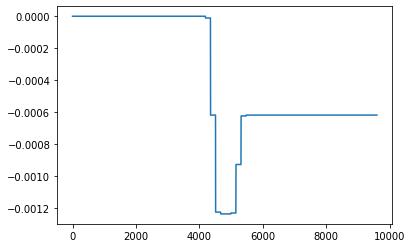

In [11]:
import matplotlib.pyplot as plt

weights = con_monitor.get('w')[:,0,0]
plt.plot(weights)

In [12]:
delta_w = []

prev_weight = 0
for check_time in check_times:
    delta_w.append(weights[check_time] - prev_weight)
    prev_weight = weights[check_time]

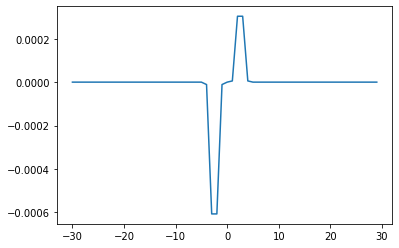

In [13]:
plt.plot(
    list(range(-30,30)),
    delta_w
)